In [74]:
## GeoPattern object
import math
import pyproj
from pyproj import Transformer
import numpy as np
import matplotlib.pyplot as plt

class Checkpoint:
    def __init__(self, lon, lat):
        # 121.42875239,31.02189847 (bottom left point of the Nanti soccer field of SJTU
        # 636427.445,3434278.842
        self.lat = lat
        self.lon = lon

    def get_coords(self):
        return self.lon, self.lat

    def to_local_crs(self):
        # Define the WGS84 coordinate reference system
        wgs84 = pyproj.CRS("EPSG:4326")

        # Define the Shanghai local CRS (e.g., EPSG:4549)
        # China Geodetic Coordinate System 2000 / 3-degree Gauss-Kruger CM 120E
        local_crs = pyproj.CRS("EPSG:4549")

        # Create a transformer to convert coordinates between the two CRS
        transformer = Transformer.from_crs(wgs84, local_crs)

        # Transform the WGS84 coordinates to the local CRS
        local_x, local_y = transformer.transform(self.lat, self.lon)

        return local_y, local_x


# Example usage:
checkpoint = Checkpoint(121.42875239,31.02189847)
local_x, local_y = checkpoint.to_local_crs()
print(f"Local coordinates: X = {local_x}, Y = {local_y}")


Local coordinates: X = 636427.4305303936, Y = 3434278.9529457837


In [134]:
from math import sin, cos, sqrt, atan2, radians, asin, degrees

def haversine(lat1, lon1, lat2, lon2):
    R = 6371e3  # 地球半径，单位：米

    lat1_rad = radians(lat1)
    lon1_rad = radians(lon1)
    lat2_rad = radians(lat2)
    lon2_rad = radians(lon2)

    d_lat = lat2_rad - lat1_rad
    d_lon = lon2_rad - lon1_rad

    a = sin(d_lat / 2) ** 2 + cos(lat1_rad) * cos(lat2_rad) * sin(d_lon / 2) ** 2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    return distance


def get_new_coordinate(checkpoint, distance, angle):
    lon, lat = checkpoint.get_coords()
    angle_rad = math.radians(angle)

    wgs84 = pyproj.CRS("EPSG:4326")
    local_crs = pyproj.CRS("EPSG:4549")
    transformer = Transformer.from_crs(wgs84, local_crs)

    y, x = transformer.transform(lat, lon)

    # Calculate the new coordinate
    new_x = x + distance * math.cos(angle_rad)
    new_y = y + distance * math.sin(angle_rad)

    # Convert the local UTM coordinates back to WGS84 coordinates
    new_lat, new_lon = transformer.transform(new_y, new_x, direction="inverse")

    return Checkpoint(new_lon, new_lat)

def local_xy_to_wgs84(xy_list, local_crs_epsg=4549):
    # Define the CRS transformations
    local_crs = pyproj.CRS.from_epsg(local_crs_epsg)
    wgs84_crs = pyproj.CRS.from_epsg(4326)
    transformer = pyproj.Transformer.from_crs(local_crs, wgs84_crs, always_xy=True)

    wgs84_coords = []

    for x, y in xy_list:
        lon, lat = transformer.transform(x, y)
        wgs84_coords.append((lon, lat))

    return wgs84_coords


In [135]:
get_new_coordinate(Checkpoint(121.42875341,31.02189977), 76, 12).get_coords()

(121.42953385897906, 31.0220336281169)

In [149]:
class SoccerField:
    def __init__(self, left_bottom_checkpoint, bottom_line_direction, field_length=105, field_width=70):
        self.field_width = field_width
        self.field_length = field_length
        self.checkpoints = None
        self.trajectory = []
        self.generate_soccer_field_checkpoints(left_bottom_checkpoint, bottom_line_direction)

    def generate_soccer_field_checkpoints(self, left_bottom_checkpoint, bottom_line_direction):
        
        d_up = bottom_line_direction + 90
        d_right = bottom_line_direction
        
        penalty_box_height = 16.5
        penalty_box_width = 40.3
        dis_corner2penalty_box = (self.field_width- penalty_box_width) / 2
        
        left_bottom = left_bottom_checkpoint  # 左下角
        left_top = get_new_coordinate(left_bottom, self.field_width, d_up)  # 左上角
        right_bottom = get_new_coordinate(left_bottom, self.field_length, d_right)  # 右下角
        right_top = get_new_coordinate(right_bottom, self.field_width, d_up)  # 右上角
        
        top_mid = get_new_coordinate(left_top, self.field_length / 2, d_right)  # 上中点
        bottom_mid = get_new_coordinate(left_bottom, self.field_length / 2, d_right) # 下中点
        center = get_new_coordinate(bottom_mid, self.field_width / 2, d_up) # 下中点
        
        left_penalty_box_bottom_right = get_new_coordinate(left_bottom, dis_corner2penalty_box, d_up)  # 左禁区右下角
        left_penalty_box_top_right = get_new_coordinate(left_penalty_box_bottom_right, penalty_box_height, d_right)  # 左禁区右上角
        left_penalty_box_bottom_left = get_new_coordinate(left_penalty_box_bottom_right, penalty_box_width, d_up)  # 左禁区左下角
        left_penalty_box_top_left = get_new_coordinate(left_penalty_box_top_right, penalty_box_width, d_up)  # 左禁区左上角

        right_penalty_box_bottom_left = get_new_coordinate(right_bottom, dis_corner2penalty_box, d_up)  # 右禁区左下角
        right_penalty_box_top_left = get_new_coordinate(right_penalty_box_bottom_left, penalty_box_height, d_right + 180)  # 右禁区左上角
        right_penalty_box_bottom_right = get_new_coordinate(right_penalty_box_bottom_left, penalty_box_width, d_up)  # 右禁区右下角
        right_penalty_box_top_right = get_new_coordinate(right_penalty_box_top_left, penalty_box_width, d_up)  # 右禁区右上角


        self.checkpoints = {
        'left_bottom': left_bottom,  # 左下角
        'left_top': left_top,  # 左上角
        'right_bottom': right_bottom,  # 右下角
        'right_top': right_top,  # 右上角
        'top_mid': top_mid,  # 中
        'bottom_mid': bottom_mid,  # 中
        'center': center,
        'left_penalty_box_bottom_left': left_penalty_box_bottom_left,  # 左禁区左下角
        'left_penalty_box_top_left': left_penalty_box_top_left,  # 左禁区左上角
        'left_penalty_box_bottom_right': left_penalty_box_bottom_right,  # 左禁区右下角
        'left_penalty_box_top_right': left_penalty_box_top_right,  # 左禁区右上角
        'right_penalty_box_bottom_left': right_penalty_box_bottom_left,  # 右禁区左下角
        'right_penalty_box_top_left': right_penalty_box_top_left,  # 右禁区左上角
        'right_penalty_box_bottom_right': right_penalty_box_bottom_right,  # 右禁区右下角
        'right_penalty_box_top_right': right_penalty_box_top_right,  # 右禁区右上角
        }
        return self.checkpoints

    def generate_trajectory(self, mode="wgs", resolution=0.1):
        points = []

        traversal_keys = ["left_bottom",
                          "left_penalty_box_bottom_right", "left_penalty_box_top_right", "left_penalty_box_top_left", "left_penalty_box_bottom_left",
                          "left_penalty_box_bottom_right", "left_top",
                          "top_mid", "center", "top_mid", "right_top",
                          'right_penalty_box_bottom_right', 'right_penalty_box_top_right', 'right_penalty_box_top_left', 'right_penalty_box_bottom_left','right_penalty_box_bottom_right',
                          "right_bottom", "bottom_mid", "center", "bottom_mid", "left_bottom"
                          ]

        for key in traversal_keys:
            points.append(self.checkpoints[key].to_local_crs())

        distances = [np.linalg.norm(np.array(points[i + 1]) - np.array(points[i])) for i in range(len(points) - 1)]

        num_points = [int(dist / resolution) for dist in distances]

        for i in range(len(points) - 1):
            start = np.array(points[i])
            end = np.array(points[i + 1])
            step = (end - start) / num_points[i]
            for j in range(num_points[i]):
                self.trajectory.append(start + j * step)

        self.trajectory.append(points[-1])

        return self.trajectory

# enhance the SoccerField class with corner arcs and central circle



In [150]:
class GeoPattern:

    def __init__(self, left_bottom_checkpoint_, bottom_line_direction_, field_type, length=105, width=68):
        self.field_length = length  # 足球场长度（米）
        self.field_width = width  # 足球场宽度（米）
        self.field = field_type(left_bottom_checkpoint_, bottom_line_direction_, length, width)
        self.trajectory = local_xy_to_wgs84(self.field.generate_trajectory())

    def plot_trajectory(self):
        x,y = zip(*self.trajectory)
        plt.plot(x, y, marker='o')
        plt.xlabel('Easting (X)')
        plt.ylabel('Northing (Y)')
        plt.axis('equal')
        plt.title('Soccer Field Trajectory')
        plt.grid()
        plt.show()

    def save_trajectory_to_file(self, filename):
        with open(filename, 'w') as file:
            file.write('Easting,Northing\n')
            for point in self.trajectory:
                file.write(f'{point[0]},{point[1]}\n')

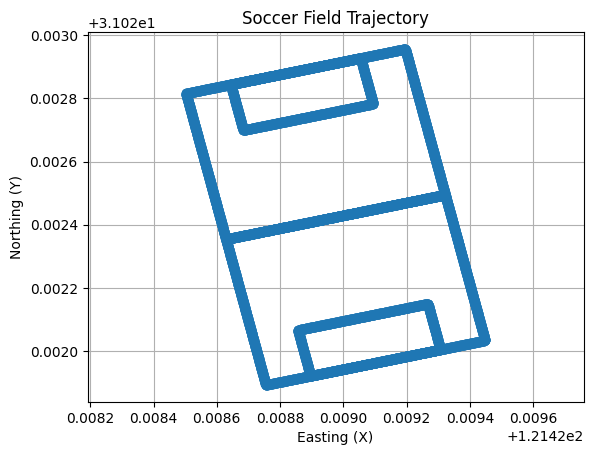

In [151]:
left_bottom_checkpoint = Checkpoint(121.4294481,31.0220344)  # 请使用实际坐标
bottom_line_direction = 104  # 向东为0度，向北为90度

geo_pattern = GeoPattern(left_bottom_checkpoint, bottom_line_direction, SoccerField)

geo_pattern.plot_trajectory()
geo_pattern.save_trajectory_to_file('trajectory.csv')
